# 1D Token-Sequence Prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import contextlib
from scipy.stats import skew, kurtosis
from scipy.spatial import distance
from statsmodels.tsa.stattools import acf, pacf
from collections import Counter
import matplotlib.pyplot as plt
from torchviz import make_dot

import gymnasium
from gymnasium import spaces
from copy import deepcopy
from typing import Any, ClassVar, Dict, List, Optional, Type, TypeVar, Union

from stable_baselines3.common.distributions import CategoricalDistribution
from stable_baselines3.common.utils import constant_fn
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance, get_schedule_fn, obs_as_tensor
from stable_baselines3.common.vec_env import VecEnv
from sb3_contrib import RecurrentPPO
from sb3_contrib.common.recurrent.buffers import RecurrentDictRolloutBuffer, RecurrentRolloutBuffer
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib.common.recurrent.type_aliases import RNNStates
from stable_baselines3.common.policies import ActorCriticPolicy
from sb3_contrib.ppo_recurrent.policies import CnnLstmPolicy, MlpLstmPolicy, MultiInputLstmPolicy

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Data Preparation

##### Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$


$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

$W_t \sim \mathcal{N}(0, t)$

$dW_t \approx W_{t+\Delta t} - W_t \sim \mathcal{N}(0, \Delta t)$

$\ln(S_t) \sim \mathcal{N}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$S_t \sim \text{LogNormal}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$dS_t \sim \mathcal{N}(\mu S_t dt, \sigma^2 S_t^2 dt)$


In [2]:
def gbm_simulator(key, S0, mu, sigma, T, dt, n):
    # Time vector
    t = jnp.linspace(0, T, n)
    # Generate Wiener process increments
    W_increments = random.normal(key, (n,)) * jnp.sqrt(dt)
    # Cumulative sum to get the Wiener process
    W = jnp.cumsum(W_increments)   
    # Geometric Brownian Motion
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)   
    return t, S

In [3]:
S0 = 100.0      # Initial stock price
mu = 0.05       # Drift coefficient (e.g., 1% annual drift)
sigma = 0.2     # Volatility coefficient (e.g., 20% annual volatility)
T = 10.0        # Total time (5 year)
n = 100000      # Number of time steps
dt = T / n      # Time step size

# Seed 14
key = random.PRNGKey(14)

# Simulate GBM
t, Price_GBM = gbm_simulator(key, S0, mu, sigma, T, dt, n)

# Price Deltas
Delta_GBM = jnp.diff(Price_GBM)

Data Illustration

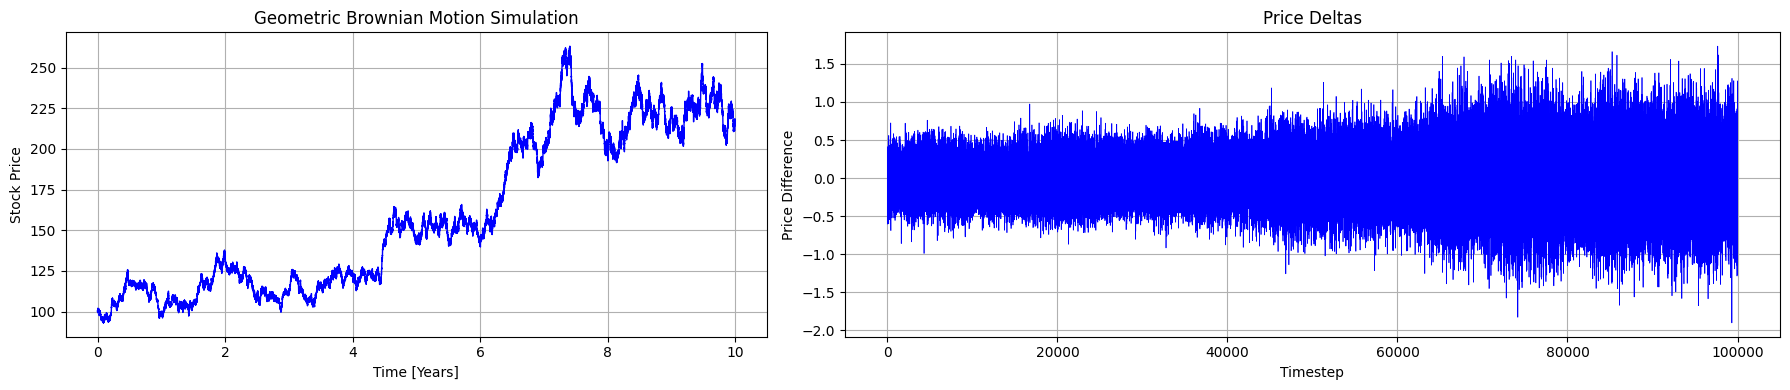

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4), gridspec_kw={'width_ratios': [1.5, 2]})
axs[0].plot(t, Price_GBM, color='blue', linewidth=1)
axs[0].set_title('Geometric Brownian Motion Simulation')
axs[0].set_xlabel('Time [Years]')
axs[0].set_ylabel('Stock Price')
axs[0].grid('True')

axs[1].plot(Delta_GBM, color='blue', linewidth=0.5)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Price Difference')
axs[1].grid('True')
plt.tight_layout()
plt.show()

BINWIDTH

In [5]:
bin_width = 0.05

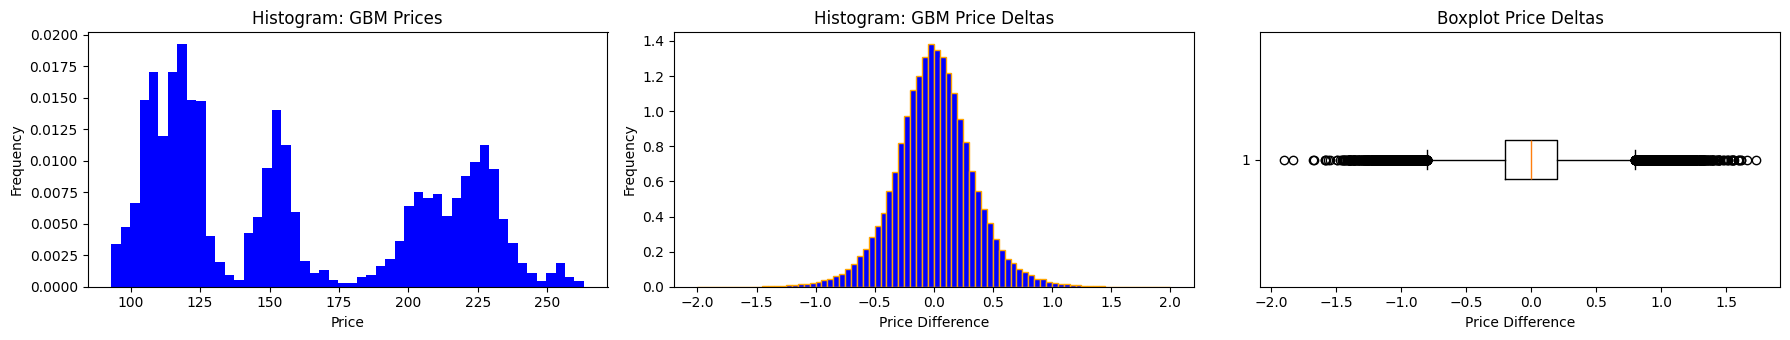

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM, bins=50, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-2, 2 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM, bins=bins, edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM, vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


Discretizing Data and Train-Val-Test Split

In [7]:
data = np.array(Delta_GBM)

# Bin range and Bin width
bin_start = -2
bin_stop = 2

num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

# Tokenize the data
tokenized_data = np.digitize(data, bins=bin_edges, right=False) - 1

# Clip any deltas below -0.7 to the first bin and above 0.7 to the last bin
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)

# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.6, shuffle=False)
val_data_temp, test_data_temp = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

print('Number of Tokens:', num_bins)

Number of Tokens: 80


LSTM Model

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # A sequence of 50 tokens is passed to the embedding layer and we get the embeddings for each token (dimension: 32)
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim] [1, 50, 32]
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Input: 50 tokens, Output: 50 hidden states with dimension 64
        # Apply fully connected layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]
        
        return logits, (h_n, c_n)                               # Return predictions for each time step

#### Train setting:

| Train set:                           |     $\approx$ 60'000         |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |
| Sequences for a full epoch:          | $\approx$ 1200               |
| **Batch size:**                      | **512**                      |
| Episode length:                      | 1 Batch or 512 sequences     |


PARAMETERS

In [8]:
seq_len = 50                                                    # Sequence Length
batch_size = 512                                                # Batch Size
learning_rate = 0.001                                           # Learning Rate Adam Optimizer
num_episodes = int(len(train_data_temp)/(seq_len*batch_size))   # Number of episodes for one Epoch

num_epochs = 1000

VALIDATION & TEST DATA

In [11]:
n_val_seq = len(val_data_temp) // seq_len
val_data = [val_data_temp[i*seq_len:(i+1)*seq_len] for i in range(32)]

In [12]:
n_val_seq = len(val_data_temp) // seq_len
val_data = [val_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_val_seq)]

n_test_seq = len(test_data_temp) // seq_len
test_data = [test_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_test_seq)]

TRAINING

In [ ]:
ss_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ss_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    avg_train_loss = 0
    avg_val_loss = 0

    for episode in range(num_episodes):

        ## ============
        ## TRAINING
        ## ============

        ss_model.train()
        ss_model.zero_grad()

        # Sample the Batch 
        start_train_idx = np.random.choice(range(len(train_data_temp) - seq_len), size=batch_size, replace=True)
        train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)

        # Create Tensor of Sequence and Target

        sequence_inputs = torch.tensor(np.array([seq[:-1] for seq in train_data]))    # Remove Last Token
        targets = torch.tensor(np.array([seq[1:] for seq in train_data]))             # Remove First Token

        # Forward pass: Shape [batch_size, sequence_length - 1, output_dim]
        logits, abc = ss_model(sequence_inputs, None)

        # [batch_size*sequence_length-1, output_dim/unique Tokens]
        logits = logits.view(-1, logits.size(-1))
        # Flatten targets: [batch_size*sequence_length-1]
        targets = targets.view(-1)

        loss = criterion(logits, targets)          # Loss
        ss_model.zero_grad()
        loss.backward()                            # Backward pass
        optimizer.step()                           # Update weights
        avg_train_loss += loss.item()              # Save Loss

        ## ============
        ## VALIDATION
        ## ============
        
        ss_model.eval()
        
        sequence_inputs = torch.tensor([seq[:-1] for seq in val_data])  # Remove Last Token
        targets = torch.tensor([seq[1:] for seq in val_data])
        
        with torch.no_grad():
            logits, _ = ss_model(sequence_inputs, None) # Forward Pass
            logits = logits.view(-1, logits.size(-1))   # Flatten Logits
            targets = targets.view(-1)                  # Flatten targets
            loss = criterion(logits, targets)           # Loss
            avg_val_loss += loss.item()                 # Save Loss

    epoch_train_loss = avg_train_loss/num_episodes      # Avg Train Loss after Epoch
    epoch_val_loss = avg_val_loss/num_episodes          # Avg Val Loss after Epoch
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = best_val_loss
        torch.save(ss_model.state_dict(), 'ss_model_weights.pth')
    
    print(f"Epoch {epoch} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Loss and Entropy

In [15]:
def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities.values())
    return entropy

In [16]:
print('Entropy of Validation Data:', round(calculate_entropy(val_data_temp), 4))

Entropy of Validation Data: 3.5243


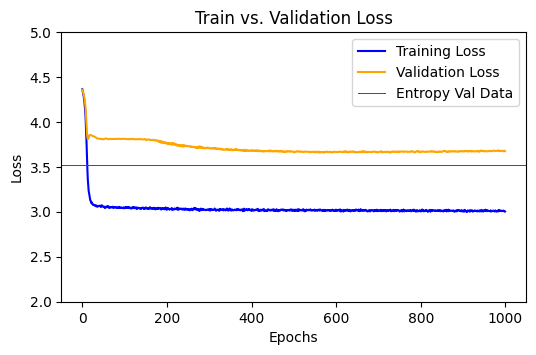

In [17]:
plt.figure(figsize=(6, 3.5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label = 'Validation Loss', color='orange')
plt.axhline(calculate_entropy(val_data_temp), color='red', linewidth=0.7, label='Entropy Val Data')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(2,5)
plt.legend()
plt.show()

In [245]:
# ## NUMBER OF BINS: 6
# train_loss_02 = train_losses
# val_loss_02 = val_losses
# ## NUMBER OF BINS 13
# train_loss_01 = train_losses
# val_loss_01 = val_losses
# ## NUMBER OF BINS 27
# train_loss_005 = train_losses
# val_loss_005 = val_losses

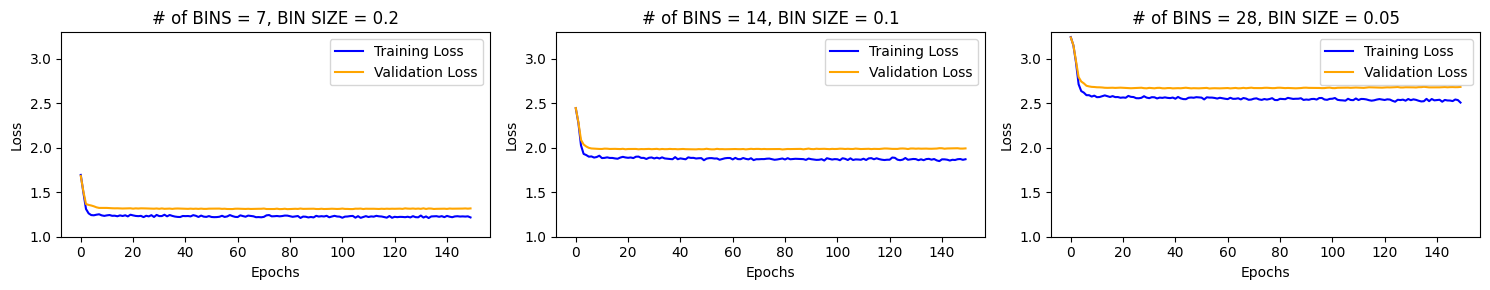

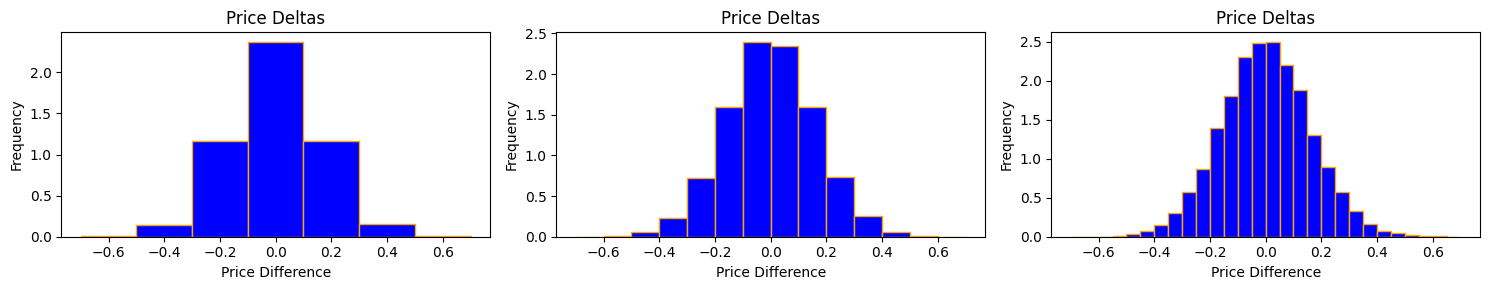

In [277]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,3))

axs[0].plot(train_loss_02, label='Training Loss', color='blue')
axs[0].plot(val_loss_02, label = 'Validation Loss', color='orange')
axs[0].set_title('# of BINS = 7, BIN SIZE = 0.2')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(1,3.3)
axs[0].legend()

axs[1].plot(train_loss_01, label='Training Loss', color='blue')
axs[1].plot(val_loss_01, label = 'Validation Loss', color='orange')
axs[1].set_title('# of BINS = 14, BIN SIZE = 0.1')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(1,3.3)
axs[1].legend()

axs[2].plot(train_loss_005, label='Training Loss', color='blue')
axs[2].plot(val_loss_005, label = 'Validation Loss', color='orange')
axs[2].set_title('# of BINS = 28, BIN SIZE = 0.05')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].set_ylim(1,3.3)
axs[2].legend()

plt.tight_layout()
plt.show()

bins_005 = np.arange(-0.7, 0.7 + 0.05, 0.05)
bins_01 = np.arange(-0.7, 0.7 + 0.1, 0.1)
bins_02 = np.arange(-0.7, 0.7 + 0.2, 0.2)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,3))

# Histogram: GBM Price Deltas
axs[0].hist(Delta_GBM, bins=bins_02, edgecolor='orange', color='blue', density=True)
axs[0].set_title('Price Deltas')
axs[0].set_xlabel('Price Difference')
axs[0].set_ylabel('Frequency')

axs[1].hist(Delta_GBM, bins=bins_01, edgecolor='orange', color='blue', density=True)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

axs[2].hist(Delta_GBM, bins=bins_005, edgecolor='orange', color='blue', density=True)
axs[2].set_title('Price Deltas')
axs[2].set_xlabel('Price Difference')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### EVALUATION AND TESTING with Teacher forcing

In [18]:
evaluation_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
evaluation_model.load_state_dict(torch.load('ss_model_weights.pth', weights_only=False))

val_loss = []
val_perplexity = []

test_loss = []
test_perplexity = []

evaluation_model.eval()
with torch.no_grad():
    
    # Validation Data
    for sequence in val_data:
        
        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input, None)          # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49]
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        val_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        val_perplexity.append(perplexity)
    
    for sequence in test_data:

        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input, None)          # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49] 
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        test_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        test_perplexity.append(perplexity)

Perplexity Score


$\text{PP}_N(x) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{1:i-1})\right)$

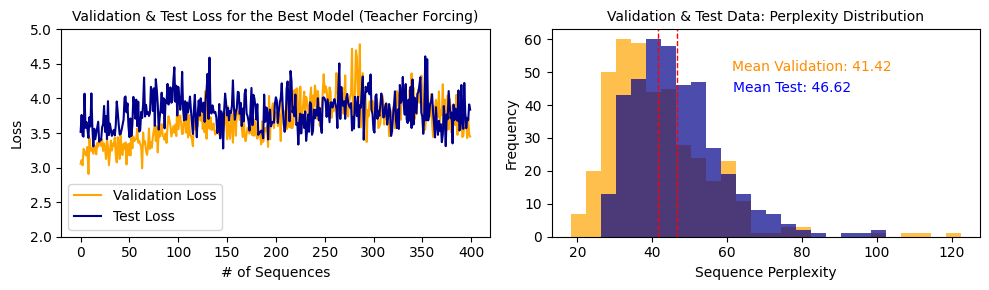

In [19]:
val_perplexity = np.array(val_perplexity)
test_perplexity = np.array(test_perplexity)

mean_test = np.mean(test_perplexity)
mean_val = np.mean(val_perplexity)

bin_start = min(np.min(val_perplexity), np.min(test_perplexity))
bin_stop = max(np.max(val_perplexity), np.max(test_perplexity))
bin_width = 4
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot 1: Validation & Test Loss
axs[0].plot(val_loss, label='Validation Loss', color='orange')
axs[0].plot(test_loss, label='Test Loss', color='darkblue')
axs[0].legend()
axs[0].set_title('Validation & Test Loss for the Best Model (Teacher Forcing)', size=10)
axs[0].set_xlabel('# of Sequences')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(2,5)

# Plot 2: Histogram of Perplexity Distribution
axs[1].hist(val_perplexity, color='orange', bins=bin_edges, alpha=0.7, label='Validation Perplexity')
axs[1].hist(test_perplexity, color='darkblue', bins=bin_edges, alpha=0.7, label='Test Perplexity')
axs[1].set_title('Validation & Test Data: Perplexity Distribution', size=10)
axs[1].set_xlabel('Sequence Perplexity')
axs[1].set_ylabel('Frequency')
#axs[1].set_xlim(1,15)

#Vertical lines for the mean values on the histogram
axs[1].axvline(mean_val, color='red', linewidth=1, linestyle='dashed')
axs[1].axvline(mean_test, color='red', linewidth=1, linestyle='dashed')
axs[1].text(mean_val+20.0, axs[1].get_ylim()[1] * 0.8, f'Mean Validation: {mean_val:.2f}', color='darkorange')
axs[1].text(mean_test+15.0, axs[1].get_ylim()[1] * 0.7, f'Mean Test: {mean_test:.2f}', color='blue')

plt.tight_layout()
plt.show()


#### Inference on Test Data

In [20]:
test_losses = []
trajectories = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(1, 1, 64)
        c_n = torch.zeros(1, 1, 64)
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, (h_n, c_n) = evaluation_model(sequence_input, (h_n, c_n))

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        trajectories.append(sim_trajectory)

Entropy of the Distribution (Test data)

Shannon Entropy  $H(\text{x}) = - \sum_{i} p(\text{x}_i) \log p(\text{x}_i)$

Shannon Entropy in bits  $H(\text{x}) = - \sum_{i} p(\text{x}_i) \bf{\log_2 p(\text{x}_i)}$


In [21]:
def calculate_entropy_bits(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log2(p) for p in probabilities.values())
    return entropy

In [22]:
pure_fake = [trajectories[i][1:] for i in range(len(trajectories))]
flatten_fake = [token for seq in pure_fake for token in seq]

real_entropy = round(calculate_entropy(test_data_temp), 4)
fake_entropy = round(calculate_entropy(flatten_fake), 4)

real_seq_entropy = []
fake_seq_entropy = []

for i in range(len(test_data)):
    real_seq_entropy.append(calculate_entropy(test_data[i]))
    fake_seq_entropy.append(calculate_entropy(pure_fake[i]))

mean_real = np.mean(real_seq_entropy)
mean_fake = np.mean(fake_seq_entropy)

bin_start = min(np.min(real_seq_entropy), np.min(fake_seq_entropy))
bin_stop = max(np.max(real_seq_entropy), np.max(fake_seq_entropy))
bin_width = 0.05
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)


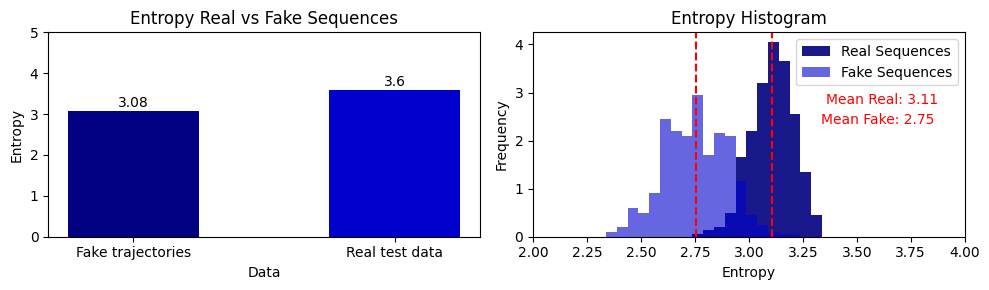

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot Barplot
bars = axs[0].bar(x = ['Fake trajectories', 'Real test data'], height=[fake_entropy, real_entropy], width=0.5, color=['navy', 'mediumblue'])
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
axs[0].set_title('Entropy Real vs Fake Sequences')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Entropy')
axs[0].set_ylim(0, 5)

# Plot histograms
axs[1].hist(real_seq_entropy, bins=bin_edges, color='navy', alpha=0.9, label='Real Sequences', density=True)
axs[1].hist(fake_seq_entropy, bins=bin_edges, color='mediumblue', alpha=0.6, label='Fake Sequences', density=True)

# Plot vertical lines for means
axs[1].axvline(mean_real, color='red', linewidth=1.5, linestyle='dashed')
axs[1].axvline(mean_fake, color='red', linewidth=1.5, linestyle='dashed')
y_limit = axs[1].get_ylim()[1]
axs[1].text(mean_real + 0.25, y_limit * 0.65, f'Mean Real: {mean_real:.2f}', color='red')
axs[1].text(mean_fake + 0.58, y_limit * 0.55, f'Mean Fake: {mean_fake:.2f}', color='red')

# Set titles and labels
axs[1].set_title('Entropy Histogram')
axs[1].set_xlabel('Entropy')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(2,4)
axs[1].legend()

plt.tight_layout()
plt.show()

#print(f"\033[0mREAL DATA Token level entropy:\033[1m {real_entropy}")
#print(f"\033[0mFAKE DATA Token level entropy:\033[1m {fake_entropy}")


In [24]:
def kl_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # KL divergence
    kl_divergence = 0
    for token, p_real in real_probabilities.items():
        p_fake = fake_probabilities.get(token, 1e-10)  # Small value to avoid division by zero
        kl_divergence += p_real * np.log2(p_real / p_fake)
    
    return kl_divergence

def kl_jl(p_real, p_fake):

    kl_divergence = 0
    for token, p_r in p_real.items():
        p_f = p_fake.get(token, 1e-10)  # Add a small value to avoid division by zero
        kl_divergence += p_r * np.log2(p_r / p_f)
    return kl_divergence

def calculate_js_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # Average distribution M
    all_tokens = set(real_probabilities.keys()).union(set(fake_probabilities.keys()))
    average_probabilities = {token: 0.5 * (real_probabilities.get(token, 0) + fake_probabilities.get(token, 0)) for token in all_tokens}
    
    # KL divergence between real and average, and fake and average
    kl_real_to_avg = kl_jl(real_probabilities, average_probabilities)
    kl_fake_to_avg = kl_jl(fake_probabilities, average_probabilities)
    
    # Calculate JS divergence
    js_divergence = 0.5 * (kl_real_to_avg + kl_fake_to_avg)
    
    return js_divergence

KL Divergence

$D_{KL}(P_{\text{real}} \parallel P_{\text{fake}}) = \sum_{i} p_{\text{real}}(x_i) \log \left( \frac{p_{\text{real}}(x_i)}{p_{\text{fake}}(x_i)} \right)$

Jensen-Shannon Divergence


$D_{JS}(P_{\text{real}} \parallel P_{\text{fake}}) = \frac{1}{2} D_{KL}(P_{\text{real}} \parallel M) + \frac{1}{2} D_{KL}(P_{\text{fake}} \parallel M)$, 

$\text{where } M = \frac{1}{2} (P_{\text{real}} + P_{\text{fake}})$


In [25]:
kl_div = round(kl_divergence(train_data_temp, flatten_fake),4)
js_div = round(calculate_js_divergence(test_data_temp, flatten_fake),4)

print("KL Divergence between Real and Fake Sequences (in bits):", kl_div)
print('')
print("JS Divergence between Real and Fake Sequences (in bits):", js_div)


KL Divergence between Real and Fake Sequences (in bits): 0.0066

JS Divergence between Real and Fake Sequences (in bits): 0.0806


#### Summary Statistics

In [26]:
def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(pure_fake)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.2
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 5
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

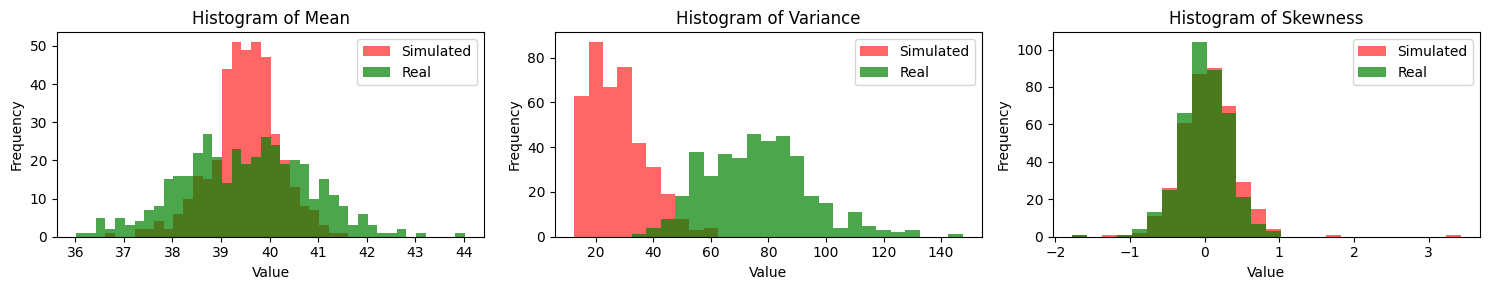

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.6, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.7, label='Real', color='green')
axs[0].legend(loc='upper right')
axs[0].set_title('Histogram of Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.6, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.7, label='Real', color='green')
axs[1].legend(loc='upper right')
axs[1].set_title('Histogram of Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.6, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.7, label='Real', color='green')
axs[2].legend(loc='upper right')
axs[2].set_title('Histogram of Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Trajectories

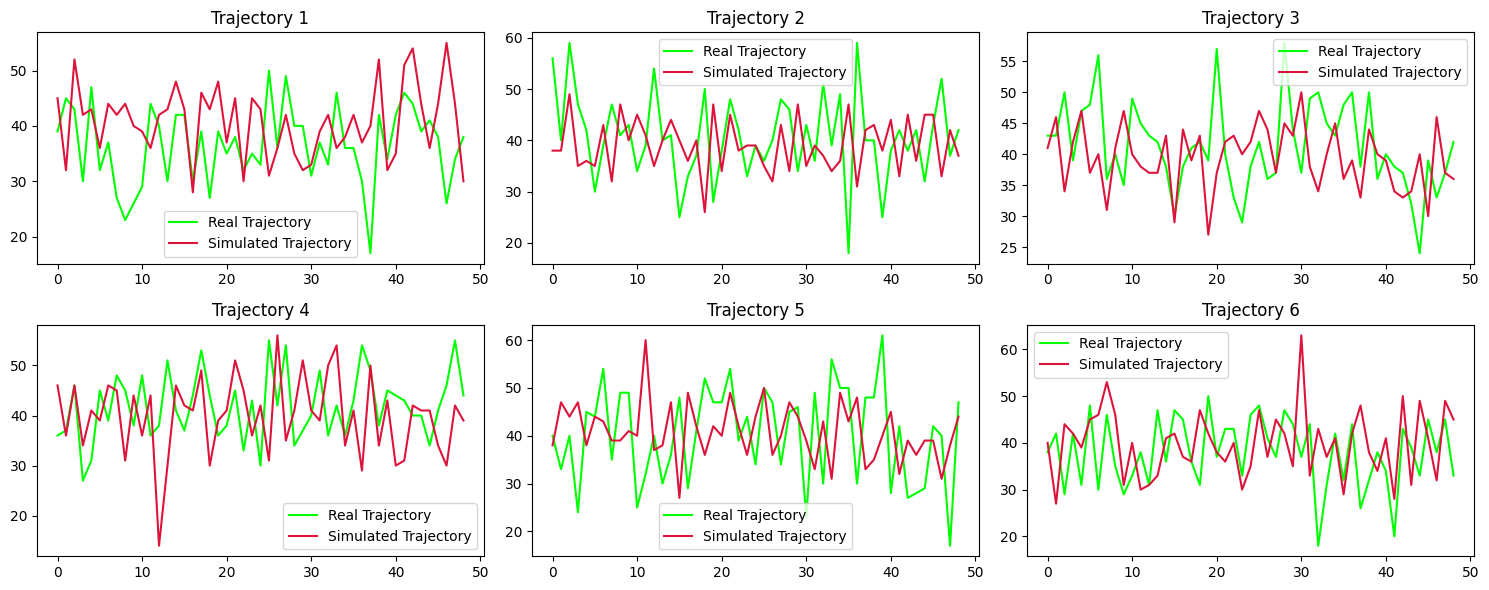

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i][1:], label='Real Trajectory', color = 'lime')
    axes[i].plot(pure_fake[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Inference with ARGMAX instead of SAMPLING next TOKEN

In [29]:
test_losses_2 = []
trajectories_2 = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(1, 1, 64)
        c_n = torch.zeros(1, 1, 64)
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, (h_n, c_n) = evaluation_model(sequence_input, (h_n, c_n))

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.argmax(probs).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses_2.append(token_loss/len(sequence))
        trajectories_2.append(sim_trajectory)

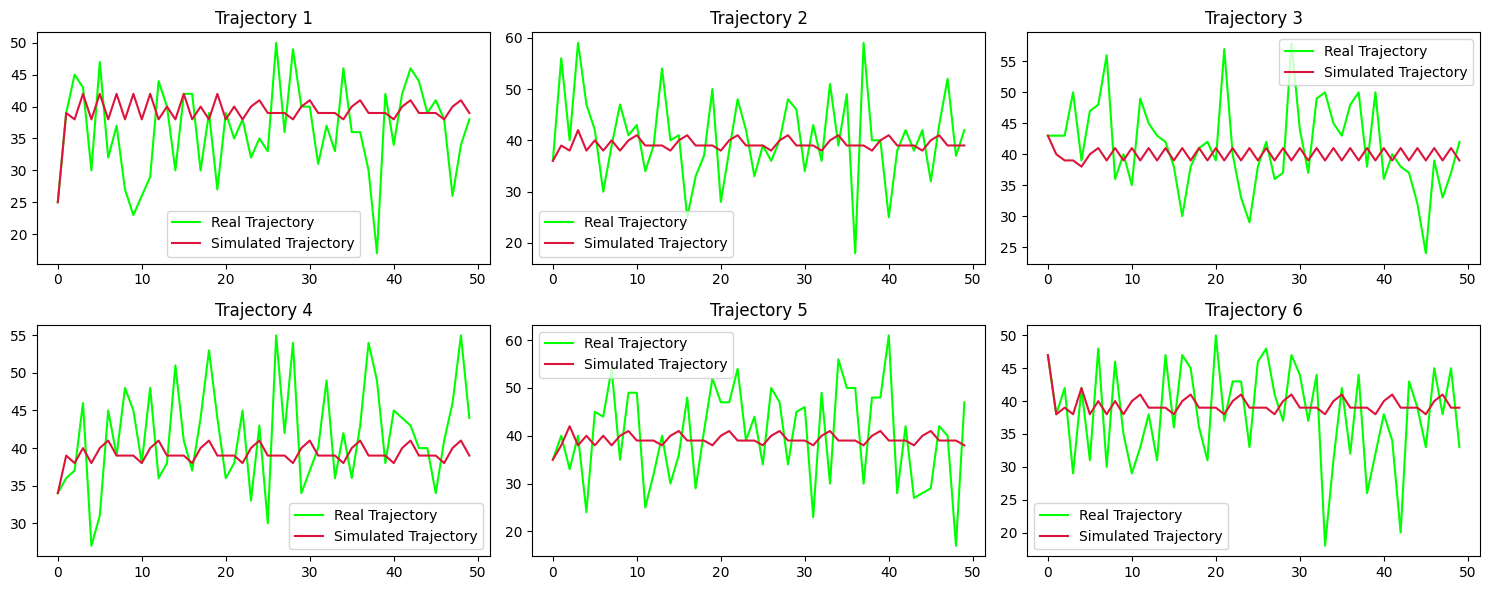

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'lime')
    axes[i].plot(trajectories_2[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Autocorrelation

$ACF(k) = Corr(x_t, x_{t-k})$

In [31]:
# Function to calculate ACF for each trajectory
def calculate_acf(trajectories, nlags=10):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

# Function to calculate PACF for each trajectory
def calculate_pacf(trajectories, nlags=10):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

# ACFs for real and simulated trajectories
real_acfs = calculate_acf([test_data[i][1:] for i in range(len(test_data))])
simulated_acfs = calculate_acf(pure_fake)
# Average the ACFs across all trajectories
avg_real_acf = np.mean(real_acfs, axis=0)
avg_simulated_acf = np.mean(simulated_acfs, axis=0)

# Calculate PACFs for real and simulated trajectories
real_pacfs = calculate_pacf([test_data[i][1:] for i in range(len(test_data))])
simulated_pacfs = calculate_pacf(pure_fake)
# Average the PACFs across all trajectories
avg_real_pacf = np.mean(real_pacfs, axis=0)
avg_simulated_pacf = np.mean(simulated_pacfs, axis=0)

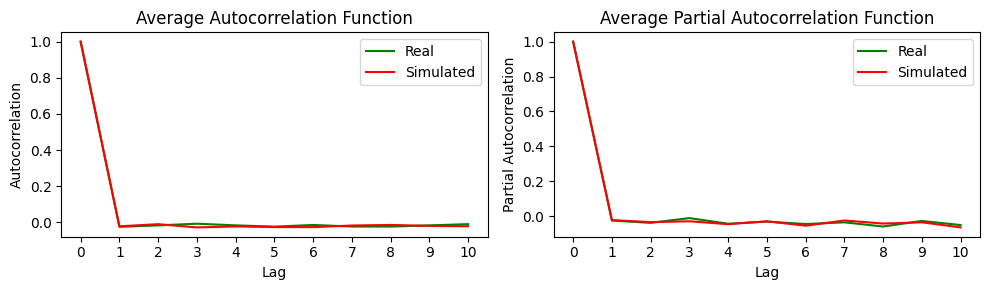

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the averaged ACFs
axs[0].plot(avg_real_acf, label='Real', color='green')
axs[0].plot(avg_simulated_acf, label='Simulated', color='red')
axs[0].set_title('Average Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xticks(np.arange(0, 11, 1))
axs[0].legend()

# Plot the averaged PACFs
axs[1].plot(avg_real_pacf, label='Real', color='green')
axs[1].plot(avg_simulated_pacf, label='Simulated', color='red')
axs[1].set_title('Average Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xticks(np.arange(0, 11, 1))
axs[1].legend()

plt.tight_layout()
plt.show()


### GAIL IMPLEMENTATION

**Policy Loss**

$L^{\text{CLIP}}(\theta) = -\mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \; \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right]$
where, $r_t(\theta) = \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}$


**Value Loss**

$L_{\text{value}} = \frac{1}{N} \sum_{t=1}^{N} \left( V(s_t) - R_t \right)^2$


**Advantage Function**

$G_t = \sum_{k=0}^{T-1} \gamma^k r_{k}$

$A_t = \sum_{i=0}^{\infty} (\gamma \lambda)^i \delta_{t+i}$

$\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots$

where:

- $\gamma$ is the discount factor.
- $\lambda$ parameter that controls the bias-variance trade-off.
- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error.


Simple Discriminator LSTM Network with binary classification

In [9]:
class GAILDiscriminator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):              # Output size is one
        super(GAILDiscriminator, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, 1)  # Output single probability
        # Sigmoid Activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden=None):
        # Input x shape: torch.Size([10, 49])
        embedded = self.embedding(x)
        # Output Embedding shape: torch.Size([10, 49, 32])
        lstm_out, hidden = self.lstm(embedded, hidden)
        # Output LSTM out shape: torch.Size([10, 49, 64])
        logits = self.fc(lstm_out)
        # Output Logits shape: torch.Size([10, 49, 1])
        prob = self.sigmoid(logits)
        # Output shape Prob: torch.Size([10, 49, 1])
        prob = prob.squeeze(-1)
        # Output shape Prob Squeezed: torch.Size([10, 49])
        return prob, hidden

Token Environment

In [10]:
class TokenEnvironmentGAIL(gymnasium.Env):
    
    def __init__(self, train_data, val_data, test_data, sequence_length, training):
        
        super(TokenEnvironmentGAIL, self).__init__()

        self.first_reset = True
        
        # Data
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.seq_len = sequence_length                      # Sequence Length

        # FOR RESET
        self.training = training                            # Training
        self.episode_counter = 0                            # Counter
        self.episode_end = False                            # End of Episode
        
        # Spaces
        self.action_space = spaces.Discrete(80)             # Action Space
        self.observation_space = spaces.Discrete(80)        # State Space

        ###============
        # DISCRIMINATOR
        ###============
        self.discriminator = GAILDiscriminator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64)
        self.hidden_states_D = (torch.zeros(1, 1, 64), torch.zeros(1, 1, 64))
        self.real_sequences = []
        self.temp_fake = []
        self.fake_sequences = []

        self.discr_BCE_loss_single_seq = []
        self.discr_BCE_loss_all_seq = []

        self.discriminator_loss = []
        self.phi_real_prob = []
        self.phi_fake_prob = []

        # Loss function and Optimizer
        self.criterion = nn.BCELoss()
        self.D_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.last_BCE_loss = self.criterion(torch.tensor(0.5), torch.tensor(0.)) 

    def step(self, action):
        
        if isinstance(action, np.ndarray):
            action = action.item()
        
        assert self.action_space.contains(action), "Invalid Action"
        
        self.temp_fake.append(action)

        with torch.no_grad():
            discr_input = torch.tensor(action, dtype=torch.long).view(1, -1)
            discr_prob, self.hidden_states_D = self.discriminator.forward(x=discr_input, hidden=self.hidden_states_D)
            # BCE LOSS as Reward
            curr_BCE_loss = self.criterion(discr_prob, torch.ones_like(discr_prob))
            curr_BCE_loss = curr_BCE_loss.item()

            self.discr_BCE_loss_single_seq.append(curr_BCE_loss)

        #print(f"Discriminator Mode: {'train' if self.discriminator.training else 'eval'}")

        ### ===============
        ###     REWARD
        ### ===============

        reward = (curr_BCE_loss - self.last_BCE_loss)

        ### ===============
        ###     REWARD
        ### ===============

        self.last_BCE_loss = curr_BCE_loss

        # Order matters!
        self.episode_counter += 1
        done = (self.episode_counter == (self.seq_len))
        
        if done:
            self.discr_BCE_loss_all_seq.append(self.discr_BCE_loss_single_seq)
            self.fake_sequences.append(np.array(self.temp_fake))

        truncated = False
        info = {}

        next_state = action

        return next_state, reward, done, truncated, info

    def reset(self, seed=None, training=True, **kwargs):

        #print('ENV: RESET')

        if seed is not None:
            np.random.seed(seed)
        
        self.episode_counter = 0
        self.episode_end = False

        self.discriminator.eval()

        self.training = training
        
        if self.training:

            # Sample a Sequence from Train Data
            start_train_idx = np.random.choice(range(len(self.train_data) - self.seq_len), size=1)
            train_sequence = self.train_data[start_train_idx.item():start_train_idx.item()+self.seq_len]
            # First value of Sequence
            start_token = train_sequence[0]
            self.real_sequences.append(train_sequence)

        else:

            start_test_idx = np.random.choice(range(len(self.test_data) - self.seq_len), size=1)
            test_sequence = self.test_data[start_test_idx.item():start_test_idx.item()+self.seq_len]
            start_token = test_sequence[0]
            self.real_sequences.append(test_sequence)
        
        self.temp_fake = []
        self.temp_fake.append(start_token)

        # Discriminator implementation
        self.last_BCE_loss = self.criterion(torch.tensor(0.5), torch.tensor(0.)) 
        
        start_token = np.array([start_token])

        return start_token, {}
    
    def train_discriminator(self):

        # if self.first_reset:
        #     self.real_sequences = self.real_sequences[1:]
        #     self.first_reset = False
    
        self.discriminator.train()

        batch_real = [torch.tensor(sequence) for sequence in self.real_sequences]
        batch_real = torch.stack(batch_real)

        batch_fake = [torch.tensor(sequence) for sequence in self.fake_sequences]
        batch_fake = torch.stack(batch_fake)
        
        ### CHECK BATCHES

        # print("")
        # print('BATCH REAL SHAPE: ', batch_real.shape)
        # print('BATCH REAL: ', batch_real)
        # print("")
        # print('BATCH FAKE SHAPE: ', batch_fake.shape)
        # print('BATCH FAKE: ', batch_fake)

        # 1. Train on real sequences (compare to 1, since 1 = real sequence)
        D_real, _ = self.discriminator.forward(x=batch_real) 
        final_prob_real = D_real[:,-1]
        D_loss_real = self.criterion(final_prob_real, torch.ones_like(final_prob_real))

        # 2. Train on fake sequence (compare to 0, since 0 = fake sequence)
        D_fake, _ = self.discriminator.forward(x=batch_fake)
        final_prob_fake = D_fake[:,-1]
        D_loss_fake = self.criterion(final_prob_fake, torch.zeros_like(final_prob_fake))

        D_loss = (D_loss_real + D_loss_fake) / 2
        
        # print('Discrimintator Weight BEFORE')
        # for name, param in self.discriminator.named_parameters():
        #     if param.requires_grad:
        #         print(f"{name}: {param.data}")

        self.D_optimizer.zero_grad()
        D_loss.backward()
        self.D_optimizer.step()

        # print('Discrimintator Weight AFTER')
        # for name, param in self.discriminator.named_parameters():
        #     if param.requires_grad:
        #         print(f"{name}: {param.data}")

        self.discriminator_loss.append(D_loss.item())
        self.phi_real_prob.append(final_prob_real.mean().item())
        self.phi_fake_prob.append(final_prob_fake.mean().item())
        
        self.discriminator.eval()

    def reset_discriminator_sequences(self):
        
        self.real_sequences = []
        self.fake_sequences = []
        self.discriminator_loss = []
        self.phi_real_prob = []
        self.phi_fake_prob = []

    def get_discrimnator_result(self):
        return self.discriminator_loss, self.phi_real_prob, self.phi_fake_prob

    def get_sequences(self):
        temp_real = self.real_sequences
        temp_fake = self.fake_sequences
        self.real_sequences = []
        self.fake_sequences = []
        return temp_real, temp_fake


Policy Class

In [11]:
class GAILPolicy(ActorCriticPolicy):
    
    def __init__(self, observation_space, action_space, lr_schedule, vocab_size, embedding_dim, hidden_dim, pretrained_weights, n_lstm_layers=1, *args, **kwargs):
        
        super(GAILPolicy, self).__init__(observation_space=observation_space, action_space=action_space, lr_schedule=lr_schedule, *args, **kwargs)
                
        ## LSTM Setup
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_lstm_layers, batch_first=True)
        self.fc_action = nn.Linear(hidden_dim, action_space.n)
        self.fc_value = nn.Linear(hidden_dim, 1)
        
        # Load pretrained weights
        if pretrained_weights:
            self.load_pretrained_weights(pretrained_weights)
        else:
            self.apply(self.init_weights)  # Apply initialization

        # Initialize the optimizer with custom parameters only
        self.optimizer = torch.optim.Adam(
            list(self.embedding.parameters()) + 
            list(self.lstm.parameters()) + 
            list(self.fc_action.parameters()) + 
            list(self.fc_value.parameters()), 
            lr=lr_schedule(1.0)
        )

        # Initialize the action distribution based on the action space
        self.action_dist = CategoricalDistribution(action_space.n)

    def forward(self, obs, lstm_states, episode_starts, deterministic=False):

        #print('POLICY: FORWARD')

        # Reset the hidden and cell state for a new sequence
        if episode_starts.any():
           lstm_states = self.reset_recurrent_states()

        # Unpack the lstm_states for the actor and critic
        (hx, cx) = lstm_states.pi
        
        obs = obs.long()
        obs = obs.unsqueeze(0)
        x = self.embedding(obs)

        # Process through the shared LSTM
        lstm_out, (hx, cx) = self.lstm(x, (hx, cx))
        # Action Head
        action_logits = self.fc_action(lstm_out)
        # Detach LSTM output for critic to prevent gradient backpropagation through LSTM
        value = self.fc_value(lstm_out.detach())
        
        # Calculate actions and log probabilities
        action_dist = self._get_action_dist_from_latent(action_logits)
        actions = action_dist.get_actions(deterministic=deterministic)
        log_probs = action_dist.log_prob(actions)

        # Need to detach hidden states for value head
        updated_lstm_states = RNNStates(pi=(hx, cx), vf=(hx.detach(), cx.detach()))

        return actions, value, log_probs, updated_lstm_states
    
    def predict_values(self, obs, lstm_states_vf, episode_starts):
        
        if episode_starts.any():
           lstm_states = self.reset_recurrent_states()
           lstm_states_vf = lstm_states.vf
        
        obs = obs.long()
        obs = obs.unsqueeze(0)
        x = self.embedding(obs)
        lstm_out, _ = self.lstm(x, lstm_states_vf)
        value = self.fc_value(lstm_out.detach())

        return value
    
    def evaluate_actions(self, obs, actions, lstm_states, episode_starts):

        obs = obs.long()
        x = self.embedding(obs)  # Embed the observations

        # Process through the shared LSTM
        lstm_out, _ = self.lstm(x, None)  # LSTM handles batch processing
         # Action head
        action_logits = self.fc_action(lstm_out)
        # Value head
        value = self.fc_value(lstm_out.detach())
        
        # Calculate action distribution
        action_dist = self._get_action_dist_from_latent(action_logits)
        log_probs = action_dist.log_prob(actions)  # Log probability for each action in the batch
        # Calculate entropy for exploration bonus
        entropy = action_dist.entropy()  # Entropy of the action distribution for each batch element

        value = value.view(-1)
        log_probs = log_probs.view(-1)
        entropy = entropy.view(-1)

        # Return values, log probabilities, and entropy
        return value, log_probs, entropy
    
    def predict(self, obs, lstm_state, deterministic=False):

        # Switch to eval mode (this affects batch norm / dropout)
        self.set_training_mode(False)
        
        with torch.no_grad():
            obs = torch.tensor(obs, dtype=torch.long)
            obs = obs.unsqueeze(0)
            x = self.embedding(obs)
            lstm_out, lstm_state = self.lstm(x, lstm_state)
            action_logits = self.fc_action(lstm_out)
            action_dist = self._get_action_dist_from_latent(action_logits)
            action = action_dist.get_actions(deterministic=deterministic)
            action = action.view(-1).numpy()

        return action, lstm_state

    def _get_action_dist_from_latent(self, latent_pi):

        return self.action_dist.proba_distribution(action_logits=latent_pi)

    def reset_recurrent_states(self):

        #print('POLICY: RESET STATES')

        hidden_shape = (self.lstm.num_layers, 1, self.lstm.hidden_size)
        hidden_state = torch.zeros(hidden_shape)
        cell_state = torch.zeros(hidden_shape)
        
        # Create separate hidden states for actor and critic    Shape [1, 1, 64]
        pi_states = (hidden_state.clone(), cell_state.clone())  # Actor states
        vf_states = (hidden_state.clone(), cell_state.clone())  # Critic states
        
        # RNNStates compatibility with RecurrentPPO
        return RNNStates(pi=pi_states, vf=vf_states)
    
    def load_pretrained_weights(self, pretrained_weigths_path):

        #print('POLICY: load_pretrained_weights')

        pretrained_dict = torch.load(pretrained_weigths_path, weights_only=False)
        # Embedding Layer
        if 'embedding.weight' in pretrained_dict:                                   
            self.embedding.weight.data.copy_(pretrained_dict['embedding.weight'])        
        # LSTM Layer
        for name, weights in self.lstm.named_parameters():
            if str('lstm.'+ name) in pretrained_dict:
                weights.data.copy_(pretrained_dict[str('lstm.'+ name)])
        # Action Head
        if 'fc.weight' in pretrained_dict and 'fc.bias' in pretrained_dict:
            self.fc_action.weight.data.copy_(pretrained_dict['fc.weight'])
            self.fc_action.bias.data.copy_(pretrained_dict['fc.bias'])

    def get_distribution(self, obs, lstm_states, episode_starts):

        if episode_starts.any():
           lstm_states = self.reset_recurrent_states()
        (hx, cx) = lstm_states.pi
        
        obs = torch.tensor(obs)
        obs = obs.long()
        obs = obs.unsqueeze(0)
        
        x = self.embedding(obs)
        lstm_out, (hx, cx) = self.lstm(x, (hx, cx))
        action_logits = self.fc_action(lstm_out)
        updated_lstm_states = RNNStates(pi=(hx, cx), vf=(hx.detach(), cx.detach()))

        return self._get_action_dist_from_latent(action_logits), updated_lstm_states

    def init_weights(self, m):
            if isinstance(m, nn.Linear):
                # Orthogonal initialization for Linear layers
                init.orthogonal_(m.weight, gain=1)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                # Orthogonal initialization for LSTM weights
                for name, param in m.named_parameters():
                    if 'weight_ih' in name or 'weight_hh' in name:
                        init.orthogonal_(param.data, gain=1)
                    elif 'bias' in name:
                        init.constant_(param.data, 0)
    
    def _build(self, lr_schedule: Schedule):
        pass
        
    def _build_mlp_extractor(self) -> None:
        pass
    
    @staticmethod
    def _process_sequence(features, lstm_states, episode_starts, lstm):
        pass

    def _predict(self, observation, lstm_states, episode_starts, deterministic):
        pass

RecurrenPPO Class

In [44]:
SelfRecurrentPPO = TypeVar("SelfRecurrentPPO", bound="RecurrentPPO")

class RecurrentPPO_GAIL(OnPolicyAlgorithm):
    """
    Proximal Policy Optimization algorithm (PPO) (clip version)
    with support for recurrent policies (LSTM).

    Based on the original Stable Baselines 3 implementation.

    Introduction to PPO: https://spinningup.openai.com/en/latest/algorithms/ppo.html

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param batch_size: Minibatch size
    :param n_epochs: Number of epoch when optimizing the surrogate loss
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param clip_range: Clipping parameter, it can be a function of the current progress
        remaining (from 1 to 0).
    :param clip_range_vf: Clipping parameter for the value function,
        it can be a function of the current progress remaining (from 1 to 0).
        This is a parameter specific to the OpenAI implementation. If None is passed (default),
        no clipping will be done on the value function.
        IMPORTANT: this clipping depends on the reward scaling.
    :param normalize_advantage: Whether to normalize or not the advantage
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param target_kl: Limit the KL divergence between updates,
        because the clipping is not enough to prevent large update
        see issue #213 (cf https://github.com/hill-a/stable-baselines/issues/213)
        By default, there is no limit on the kl div.
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: the verbosity level: 0 no output, 1 info, 2 debug
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: ClassVar[Dict[str, Type[BasePolicy]]] = {
        "MlpLstmPolicy": MlpLstmPolicy,
        "CnnLstmPolicy": CnnLstmPolicy,
        "MultiInputLstmPolicy": MultiInputLstmPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[RecurrentActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 3e-4,
        n_steps: int = 128,
        batch_size: Optional[int] = 128,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        clip_range: Union[float, Schedule] = 0.2,
        clip_range_vf: Union[None, float, Schedule] = None,
        normalize_advantage: bool = True,
        ent_coef: float = 0.0,
        vf_coef: float = 0.5,
        max_grad_norm: float = 0.5,
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        target_kl: Optional[float] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[torch.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            seed=seed,
            device=device,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )
        
        # Custom
        self.sequence_len = self.env.envs[0].seq_len
        self.training_metrics = {
        "entropy_loss": [],
        "policy_gradient_loss": [],
        "value_loss": [],
        "approx_kl": [],
        "clip_fraction": [],
        "loss": [],
        "explained_variance": [],
        "clip_range": [],
        "clip_range_vf": [],
        "n_updates": [],
        "ep_rew_mean": []
    }

        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.clip_range = clip_range
        self.clip_range_vf = clip_range_vf
        self.normalize_advantage = normalize_advantage
        self.target_kl = target_kl
        self._last_lstm_states = None

        if _init_setup_model:
            self._setup_model()

        self.discriminator_loss = []
        self.discriminator_prob_real = []
        self.discriminator_prob_fake = []

    def _setup_model(self) -> None:
        self._setup_lr_schedule()
        self.set_random_seed(self.seed)

        buffer_cls = RecurrentDictRolloutBuffer if isinstance(self.observation_space, spaces.Dict) else RecurrentRolloutBuffer

        self.policy = self.policy_class(
            self.observation_space,
            self.action_space,
            self.lr_schedule,
            use_sde=self.use_sde,
            **self.policy_kwargs,
        )
        self.policy = self.policy.to(self.device)

        # We assume that LSTM for the actor and the critic
        # have the same architecture
        lstm = self.policy.lstm

        # if not isinstance(self.policy, RecurrentActorCriticPolicy):
        #     raise ValueError("Policy must subclass RecurrentActorCriticPolicy")

        single_hidden_state_shape = (lstm.num_layers, self.n_envs, lstm.hidden_size)
        
        # hidden and cell states for actor and critic
        self._last_lstm_states = RNNStates(
            (
                torch.zeros(single_hidden_state_shape, device=self.device),
                torch.zeros(single_hidden_state_shape, device=self.device),
            ),
            (
                torch.zeros(single_hidden_state_shape, device=self.device),
                torch.zeros(single_hidden_state_shape, device=self.device),
            ),
        )

        hidden_state_buffer_shape = (self.n_steps, lstm.num_layers, self.n_envs, lstm.hidden_size)

        self.rollout_buffer = buffer_cls(
            self.n_steps,
            self.observation_space,
            self.action_space,
            hidden_state_buffer_shape,
            self.device,
            gamma=self.gamma,
            gae_lambda=self.gae_lambda,
            n_envs=self.n_envs,
        )

        # Initialize schedules for policy/value clipping
        self.clip_range = get_schedule_fn(self.clip_range)
        if self.clip_range_vf is not None:
            if isinstance(self.clip_range_vf, (float, int)):
                assert self.clip_range_vf > 0, "`clip_range_vf` must be positive, pass `None` to deactivate vf clipping"

            self.clip_range_vf = get_schedule_fn(self.clip_range_vf)

    def collect_rollouts(
        self,
        env: VecEnv,
        callback: BaseCallback,
        rollout_buffer: RolloutBuffer,
        n_rollout_steps: int,
    ) -> bool:
        """
        Collect experiences using the current policy and fill a ``RolloutBuffer``.
        The term rollout here refers to the model-free notion and should not
        be used with the concept of rollout used in model-based RL or planning.

        :param env: The training environment
        :param callback: Callback that will be called at each step
            (and at the beginning and end of the rollout)
        :param rollout_buffer: Buffer to fill with rollouts
        :param n_steps: Number of experiences to collect per environment
        :return: True if function returned with at least `n_rollout_steps`
            collected, False if callback terminated rollout prematurely.
        """
        #print('COLLECT ROLLOUT')
        assert isinstance(
            rollout_buffer, (RecurrentRolloutBuffer, RecurrentDictRolloutBuffer)
        ), f"{rollout_buffer} doesn't support recurrent policy"

        assert self._last_obs is not None, "No previous observation was provided"
        # Switch to eval mode (this affects batch norm / dropout)
        self.policy.set_training_mode(False)

        n_steps = 0
        rollout_buffer.reset()
        # Sample new weights for the state dependent exploration

        if self.use_sde:
            self.policy.reset_noise(env.num_envs)

        callback.on_rollout_start()

        lstm_states = deepcopy(self._last_lstm_states)

        while n_steps < n_rollout_steps:
            if self.use_sde and self.sde_sample_freq > 0 and n_steps % self.sde_sample_freq == 0:
                # Sample a new noise matrix
                self.policy.reset_noise(env.num_envs)

            with torch.no_grad():
                # Convert to pytorch tensor or to TensorDict
                obs_tensor = obs_as_tensor(self._last_obs, self.device)
                episode_starts = torch.tensor(self._last_episode_starts, dtype=torch.float32, device=self.device)
                actions, values, log_probs, lstm_states = self.policy.forward(obs_tensor, lstm_states, episode_starts)

            actions = actions.cpu().numpy()

            # Rescale and perform action
            clipped_actions = actions
            # Clip the actions to avoid out of bound error
            if isinstance(self.action_space, spaces.Box):
                clipped_actions = np.clip(actions, self.action_space.low, self.action_space.high)

            new_obs, rewards, dones, infos = env.step(clipped_actions)

            self.num_timesteps += env.num_envs

            # Give access to local variables
            callback.update_locals(locals())
            if not callback.on_step():
                return False

            self._update_info_buffer(infos, dones)
            n_steps += 1

            if isinstance(self.action_space, spaces.Discrete):
                # Reshape in case of discrete action
                actions = actions.reshape(-1, 1)

            # Handle timeout by bootstraping with value function
            # see GitHub issue #633
            for idx, done_ in enumerate(dones):
                if (
                    done_
                    and infos[idx].get("terminal_observation") is not None
                    and infos[idx].get("TimeLimit.truncated", False)
                ):
                    terminal_obs = self.policy.obs_to_tensor(infos[idx]["terminal_observation"])[0]
                    with torch.no_grad():
                        terminal_lstm_state = (
                            lstm_states.vf[0][:, idx : idx + 1, :].contiguous(),
                            lstm_states.vf[1][:, idx : idx + 1, :].contiguous(),
                        )
                        # terminal_lstm_state = None
                        episode_starts = torch.tensor([False], dtype=torch.float32, device=self.device)
                        terminal_value = self.policy.predict_values(terminal_obs, terminal_lstm_state, episode_starts)[0]
                    rewards[idx] += self.gamma * terminal_value

            rollout_buffer.add(
                self._last_obs,                         # Observation
                actions,
                rewards,
                self._last_episode_starts,              # Episode start
                values,
                log_probs,
                lstm_states=self._last_lstm_states,     # LSTM Start
            )
            
            self._last_obs = new_obs
            self._last_episode_starts = dones
            
            ### WHEN IMPLEMENTING GAIL NEED TO ADJUST THIS
            if dones:
                self._last_lstm_states = self.policy.reset_recurrent_states()
            else:
                self._last_lstm_states = lstm_states

        with torch.no_grad():
            # Compute value for the last timestep
            episode_starts = torch.tensor(dones, dtype=torch.float32, device=self.device)
            values = self.policy.predict_values(obs_as_tensor(new_obs, self.device), lstm_states.vf, episode_starts)

        rollout_buffer.compute_returns_and_advantage(last_values=values, dones=dones)

        ### WHEN IMPLEMENTING GAIL NEED TO ADJUST THIS
        self.training_metrics["ep_rew_mean"].append(np.mean(rollout_buffer.rewards)*self.sequence_len)

        callback.on_rollout_end()
    
        return True

    def get_sequences_from_rollout(self):

        rollout_data = self.rollout_buffer
        sequence_length = self.sequence_len

        sequences = []

        current_sequence = {'observations': [], 'actions': [], 'rewards': [], 'episode_starts': [], 
                            'old_values': [], 'old_log_probs': [], 'advantages': [], 'returns': []}

        for i in range(len(rollout_data.observations)):
            # Check if it's the start of a new sequence
            if rollout_data.episode_starts[i] == 1.0:
                # If there's an existing sequence, add it to the list
                if len(current_sequence['observations']) == sequence_length:
                    sequences.append(current_sequence)
                # Start a new sequence
                current_sequence = {'observations': [], 'actions': [], 'rewards': [], 'episode_starts': [], 
                                    'old_values': [], 'old_log_probs': [], 'advantages': [], 'returns': []}

            # Add data to the current sequence
            current_sequence['observations'].append(rollout_data.observations[i].item())
            current_sequence['actions'].append(rollout_data.actions[i].item())
            current_sequence['rewards'].append(rollout_data.rewards[i].item())
            current_sequence['episode_starts'].append(rollout_data.episode_starts[i].item())
            current_sequence['old_values'].append(rollout_data.values[i].item())
            current_sequence['old_log_probs'].append(rollout_data.log_probs[i].item())
            current_sequence['advantages'].append(rollout_data.advantages[i].item())
            current_sequence['returns'].append(rollout_data.returns[i].item())

        # Add the last sequence if it reaches the desired length
        if len(current_sequence['observations']) == sequence_length:
            sequences.append(current_sequence)
        
        for sequence in sequences:
        # Convert sequence data to tensors
            sequence['observations'] = torch.tensor(sequence['observations'], dtype=torch.float32).view(1, -1)
            sequence['actions'] = torch.tensor([int(action) for action in sequence['actions']], dtype=torch.long).view(1, -1)
            sequence['rewards'] = torch.tensor(sequence['rewards'], dtype=torch.float32).view(1, -1)
            sequence['episode_starts'] = torch.tensor(sequence['episode_starts'], dtype=torch.float32).view(1, -1)
            sequence['old_values'] = torch.tensor(sequence['old_values'], dtype=torch.float32).view(-1)
            sequence['old_log_probs'] = torch.tensor(sequence['old_log_probs'], dtype=torch.float32).view(-1)
            sequence['advantages'] = torch.tensor(sequence['advantages'], dtype=torch.float32).view(-1)
            sequence['returns'] = torch.tensor(sequence['returns'], dtype=torch.float32).view(-1)

        return sequences

    def print_sequences(self, sequences):
        # Iterate over each sequence
        for seq_idx, sequence in enumerate(sequences):
            print(f"\n--- Sequence {seq_idx + 1} ---\n")
            print(f"  Observation: {sequence['observations']}")
            print(f"  Action: {sequence['actions']}")
            print(f"  Reward: {sequence['rewards']}")
            print(f"  Episode Start: {sequence['episode_starts']}")
            print(f"  Values: {sequence['old_values']}")
            print(f"  Log Probabilities: {sequence['old_log_probs']}")
            print(f"  Advantages: {sequence['advantages']}")
            print(f"  Returns: {sequence['returns']}")
            print("\n--- End of Sequence ---\n")

    def data_prep_train(self) -> None:

        rollout_data = self.rollout_buffer

        for i, (obs, action, reward, ep_start, value, log_probs, advantages, ret) in enumerate(zip(
            rollout_data.observations,
            rollout_data.actions,
            rollout_data.rewards,
            rollout_data.episode_starts,
            rollout_data.values,
            rollout_data.log_probs,
            rollout_data.advantages,
            rollout_data.returns
        )): 
            if ep_start:
                print("---- New Sequence Start ----")
            print(f"Step {i}: Observation: {obs}, Action: {action}, Reward: {reward}, Episode Start: {ep_start}, Values: {value}, Log Probs: {log_probs} Advantages: {advantages}, Returns: {ret}")
                    
    def train(self) -> None:
        """
        Update policy using the currently gathered rollout buffer.
        """
        #print("START TRAINING")
        #self.data_prep_train()
        
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)
        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)
        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []
        saved_loss_all_seq = []

        continue_training = True

        # CUSTOM
        sequences = self.get_sequences_from_rollout()

        #self.print_sequences(sequences)

        for epoch in range(self.n_epochs):

            loss_list = []
            approx_kl_divs = []
            
            for sequence in sequences:

                actions = sequence['actions'].long().flatten()

                values, log_prob, entropy = self.policy.evaluate_actions(
                    obs=sequence['observations'],
                    actions=actions,
                    lstm_states=None,
                    episode_starts=None
                )

                # Advantage
                advantages = sequence['advantages']
                if self.normalize_advantage:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                # ratio between old and new policy, should be one at the first iteration
                ratio = torch.exp(log_prob - sequence['old_log_probs'])
                
                 # clipped surrogate loss
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -torch.mean(torch.min(policy_loss_1, policy_loss_2))

                # PG LOSS APPEND
                pg_losses.append(policy_loss.item())
                
                clip_fraction = torch.mean((torch.abs(ratio - 1) > clip_range).float()).item()
                clip_fractions.append(clip_fraction)

                # We have None in our case!
                if self.clip_range_vf is None:
                    # No clipping
                    values_pred = values
                else:
                    # Clip the different between old and new value
                    # NOTE: this depends on the reward scaling
                    
                    values_pred = sequence['old_values'] + torch.clamp(
                        values - sequence['old_values'], -clip_range_vf, clip_range_vf
                    )
                
                # Value loss using the TD(gae_lambda) target
                value_loss = torch.mean(((sequence['returns'] - values_pred) ** 2))
                
                # VALUE LOSS APPEND
                value_losses.append(value_loss.item())

                # Entropy loss favor exploration
                if entropy is None:
                    # Approximate entropy when no analytical form
                    entropy_loss = -torch.mean(-log_prob)
                else:
                    entropy_loss = -torch.mean(entropy)

                # ENTROPY LOSS APPEND
                entropy_losses.append(entropy_loss.item())

                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss
                loss_list.append(loss)
                saved_loss_all_seq.append(loss.item())

                # Calculate approximate form of reverse KL Divergence for early stopping
                # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                # and Schulman blog: http://joschu.net/blog/kl-approx.html
                with torch.no_grad():
                    log_ratio = log_prob - sequence['old_log_probs']
                    approx_kl_div = torch.mean(((torch.exp(log_ratio) - 1) - log_ratio)).cpu().numpy()
                    approx_kl_divs.append(approx_kl_div)
                
                if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                    continue_training = False
                    if self.verbose >= 1:
                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                    break
    
            if not continue_training:
                break
            
            ##===================###
            # Policy Training
            ###===================###

            # Perform optimization step only after all sequences have been processed
            self.policy.optimizer.zero_grad()  # Clear gradients
            total_loss = torch.mean(torch.stack(loss_list))
            total_loss.backward()  # Backpropagate accumulated loss
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)  # Clip gradients
            self.policy.optimizer.step()  # Update the policy weights
            
            ##===================###
            # Policy Training
            ###===================###

                
            ##===================###
            # Discriminator Training
            ###===================###
            # env.train_discriminator()
            # disc_loss, disc_prob_real, disc_prob_fake = env.get_discrimnator_result()
            # self.discriminator_loss.append(disc_loss)
            # self.discriminator_prob_real.append(disc_prob_real)
            # self.discriminator_prob_fake.append(disc_prob_fake)
            # env.reset_discriminator_sequences()
            ###===================###
            # Discriminator Training
            ###===================###
        

        self._n_updates += self.n_epochs
        explained_var = explained_variance(self.rollout_buffer.values.flatten(), self.rollout_buffer.returns.flatten())

        # Logs
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        self.logger.record("train/policy_gradient_loss", np.mean(pg_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/approx_kl", np.mean(approx_kl_divs))
        self.logger.record("train/clip_fraction", np.mean(clip_fractions))
        self.logger.record("train/loss", np.mean(saved_loss_all_seq))
        self.logger.record("train/explained_variance", explained_var)
        
        if hasattr(self.policy, "log_std"):
            self.logger.record("train/std", torch.exp(self.policy.log_std).mean().item())

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/clip_range", clip_range)
        
        if self.clip_range_vf is not None:
            self.logger.record("train/clip_range_vf", clip_range_vf)
        
        # Add after calculating metrics
        self.training_metrics["entropy_loss"].append(np.mean(entropy_losses))
        self.training_metrics["policy_gradient_loss"].append(np.mean(pg_losses))
        self.training_metrics["value_loss"].append(np.mean(value_losses))
        self.training_metrics["approx_kl"].append(np.mean(approx_kl_divs))
        self.training_metrics["clip_fraction"].append(np.mean(clip_fractions))
        self.training_metrics["loss"].append(loss.item())
        self.training_metrics["explained_variance"].append(explained_var)
        self.training_metrics["n_updates"].append(self._n_updates)
        self.training_metrics["clip_range"].append(clip_range)
        
        if self.clip_range_vf is not None:
            self.training_metrics["clip_range_vf"].append(clip_range_vf)

    def learn(
        self: SelfRecurrentPPO,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "RecurrentPPO",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfRecurrentPPO:
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )

    def _excluded_save_params(self) -> List[str]:
        return super()._excluded_save_params() + ["_last_lstm_states"]  # noqa: RUF005

In [45]:
# Define a function to return a constant learning rate
lr_schedule = constant_fn(2.5e-4)

model_GAIL = RecurrentPPO_GAIL(
    policy=GAILPolicy,
    env=TokenEnvironmentGAIL(train_data=train_data_temp, val_data=val_data_temp, test_data=test_data_temp, sequence_length=50, training=True),
    n_steps=500,
    n_epochs=3,
    policy_kwargs=dict(
        vocab_size=num_bins,
        embedding_dim=32,
        hidden_dim=64,
        pretrained_weights='ss_model_weights.pth'
    ),
    learning_rate=lr_schedule,
    verbose=0
)

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seq_len to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seq_len` for environment variables or `env.get_wrapper_attr('seq_len')` that will search the reminding wrappers.
  logger.warn(


In [46]:
model_GAIL.learn(total_timesteps=2000)

[tensor(0.0253, grad_fn=<AddBackward0>), tensor(0.0174, grad_fn=<AddBackward0>), tensor(0.0168, grad_fn=<AddBackward0>), tensor(0.0153, grad_fn=<AddBackward0>), tensor(0.0126, grad_fn=<AddBackward0>), tensor(0.0156, grad_fn=<AddBackward0>), tensor(0.0161, grad_fn=<AddBackward0>), tensor(0.0211, grad_fn=<AddBackward0>), tensor(0.0199, grad_fn=<AddBackward0>), tensor(0.0166, grad_fn=<AddBackward0>)]
tensor(0.0177, grad_fn=<MeanBackward0>)
[tensor(0.0198, grad_fn=<AddBackward0>), tensor(0.0167, grad_fn=<AddBackward0>), tensor(0.0190, grad_fn=<AddBackward0>), tensor(0.0126, grad_fn=<AddBackward0>), tensor(0.0172, grad_fn=<AddBackward0>), tensor(0.0203, grad_fn=<AddBackward0>), tensor(0.0159, grad_fn=<AddBackward0>), tensor(0.0151, grad_fn=<AddBackward0>), tensor(0.0163, grad_fn=<AddBackward0>), tensor(0.0110, grad_fn=<AddBackward0>)]
tensor(0.0164, grad_fn=<MeanBackward0>)
[tensor(0.0120, grad_fn=<AddBackward0>), tensor(0.0228, grad_fn=<AddBackward0>), tensor(0.0188, grad_fn=<AddBackward0>